<a href="https://colab.research.google.com/github/jaysulk/uic_fnal_linac_phase_comp/blob/Sulskis-dev/PyTorch_Longitudinal_correction_with_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
from google.colab import drive

In [120]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [122]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import torch

import scipy.fft as spft
from sklearn.linear_model import LinearRegression

In [123]:
def fetch_data(file,datacols,cuts,setdevs):

    dataset = pd.read_csv(file)
    dataset.columns = dataset.columns.str.replace("[()]", "_",regex=True)

    cols = list(dataset.filter(regex='|'.join(datacols)))

    # for set points, keep _S_ and drop _R_ if available
    # 26/02/2024: inverse the logic, keep the read and remove the set
    setdevs = ['L:%s_'%d for d in setdevs]
    cols = [col for col in cols if col not in setdevs]

    subset = dataset.loc[:,cols]
    subset.columns = subset.columns.str.replace("_R_|_S_", "",regex=True)
    subset.drop(list(subset.filter(regex=r'\.1|Time|step|iter|stamp')),axis=1, inplace=True)

    # apply data quality cuts
    if len(cuts)>0:
        subset.query(cuts,inplace=True)

    subset.dropna(inplace=True)

    return subset


In [124]:
def load_BPMphase_data_single(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            #26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cavs[i][2:]])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                    df[col] = df[col].apply(lambda x : x if x > 0 else x +360)

        dfs.append(df)

    return dfs


In [125]:
def load_BPMphase_data_multi(cavs,files,dropdevs,scan=True):
    dfs = []
    for i, file in enumerate(files):
        if scan:
            # 26/02/2024: inverse the logic, keep the read and remove the set
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',['%s_S'%cav[2:] for cav in cavs])
        else:
            df = fetch_data(file,cavs+['BF','BPM','SQ'],'',[])
        try:
            df = df.drop(list(df.filter(regex=r'20|B:|SS|SQT')), axis=1)
            df = df.drop(list(df.filter(regex=r'|'.join(dropdevs))),axis=1)
        except:
            continue
        #deal with phase jumps at +-180
        for col in df.columns:
            if abs(df[col].min()-df[col].max())>350:
                #df[col] = np.unwrap(df[col],period=360)
                if np.sign(df[col]).mean() <0:
                    df[col] = df[col].apply(lambda x : x if x < 0 else x -360)
                else:
                   df[col] = df[col].apply(lambda x : x if x > 0 else x +360)


        dfs.append(df)

    return dfs


In [126]:
def fft_array(array):
    fft_vals = spft.fft(array)
    N = len(array)
    freq = spft.fftfreq(N)
    return [freq, fft_vals]

def apply_FFT(ddfs):
    raw_ffts=[]

    for j in range(len(ddfs)):
        fft_df = ddfs[j].copy(deep=True)

        for current_device in ddfs[j].columns:
            freq, fft_vals = fft_array(list(ddfs[j][current_device]))

            fft_df[current_device] = np.abs(fft_vals)
            fft_df['freq_%s'%current_device] = freq

        raw_ffts.append(fft_df)#.apply(np.real))

    return raw_ffts

def apply_FFT_filter(df,cavs,BPM_list,tolerance=0.0005):
    ddfs2 = []

    BPMs = list(set(BPM_list).intersection(set(list(df.columns))))
    for j in range(len(cavs)):
        current_df = df.copy(deep = True)

        freq_driving, fft_vals_driving = fft_array(list(df[cavs[j]]))
        filter_freqs = freq_driving[np.argmax(np.abs(fft_vals_driving))]
        for current_device in BPMs:
            freq, fft_vals = fft_array(list(df[current_device]))
            fft_vals2 = np.zeros_like(fft_vals)

            for i in range(len(fft_vals)):
                if np.any(np.abs(np.abs(freq[i]) - filter_freqs) < tolerance):
                    fft_vals2[i] = fft_vals[i]
                else:
                    fft_vals2[i] = 0

            current_df[current_device] = spft.ifft(fft_vals2)
        ddfs2.append(current_df.apply(np.real))

    return ddfs2

In [127]:
def plot_fft(fft_data,devices,npt,nperiods):
    #%matplotlib widget
    %matplotlib inline
    for dev in devices:
        #plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='o')
        markerline, stemlines, baseline = plt.stem(fft_data['freq_%s'%dev]*npt*nperiods,fft_data['%s'%dev]*2/(npt*nperiods),label='%s'%dev[2:],markerfmt='.')
        plt.setp(stemlines, 'color', plt.getp(markerline,'color'))
        plt.setp(baseline, 'color', plt.getp(markerline,'color'))
        plt.setp(stemlines, 'linestyle', 'dotted')


    plt.xlim(0,100)
    plt.ylim(0,6)
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude (deg)')
    plt.grid()
    plt.legend(loc='upper right')

In [128]:
def calc_errors(fft_data,devices,npt,nperiods):
    for dev in devices:
        idx_noise = np.where((fft_data['freq_%s'%dev]>0.1) & (fft_data['freq_%s'%dev]<0.2))
        noise = np.mean(fft_data[dev].iloc[idx_noise]).values[0]

In [129]:
def calc_response_matrix(dfs,cavs):
    final_response_matrix = []

    for j in range(len(dfs)):
        slice_pos = np.argmax(dfs[j][cavs[j]])
        norm_val = dfs[j][cavs[j]][slice_pos]

        final_response_matrix.append(dfs[j].iloc[slice_pos]/norm_val)

    return final_response_matrix

In [130]:
####  FITTING

import torch
import torch.nn as nn

def linear_fit_to_basis(osc_array, b_vec_1, b_vec_2, noise=None):
    # Convert inputs to PyTorch tensors
    X = torch.tensor(np.column_stack((b_vec_1, b_vec_2)), dtype=torch.float32)
    y = torch.tensor(osc_array, dtype=torch.float32)

    if noise is not None:
        weights = torch.tensor(1 / noise, dtype=torch.float32)
    else:
        weights = None

    # Define a linear model
    class LinearModel(nn.Module):
        def __init__(self):
            super(LinearModel, self).__init__()
            self.linear = nn.Linear(2, 1, bias=False)  # 2 input features, 1 output

        def forward(self, x):
            return self.linear(x)

    # Initialize the model
    model = LinearModel()

    # Define the optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    if weights is not None:
        loss_fn = nn.MSELoss(reduction='none')
    else:
        loss_fn = nn.MSELoss()

    # Training loop
    for epoch in range(1000):  # Number of iterations
        optimizer.zero_grad()

        # Forward pass
        output = model(X).squeeze()

        # Apply weights to the loss if noise is provided
        if weights is not None:
            loss = (loss_fn(output, y) * weights).mean()
        else:
            loss = loss_fn(output, y)

        # Backward pass
        loss.backward()
        optimizer.step()

    # Extract coefficients (weights of the linear model)
    with torch.no_grad():
        coefs = model.linear.weight.detach().numpy().flatten()

    return coefs


In [131]:
###  BASIS SELECTION
def select_basis(final_response_matrix,basis_choice_override):

    #basis_choice_override = (0, 1) #whether to autoselect basis or not
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    basis_choice = possible_basis[np.argmin(np.abs(overlaps))]

    if basis_choice_override != None: basis_choice = basis_choice_override

    return basis_choice

In [132]:
####  DIAGNOSTICS

def show_basis_choices(final_response_matrix):
    possible_basis = list(itertools.combinations(range(len(final_response_matrix)), 2))
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in final_response_matrix]
    overlaps = [np.dot(e_normed_response[b[0]], e_normed_response[b[1]]) for b in possible_basis]

    for i in range(len(possible_basis)): print(possible_basis[i], overlaps[i])
    return None

def plot_tank_fit(cavs,target_index, basis, response_matrix):
    target = response_matrix[target_index]

    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target[idx:], response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(target[idx:], label = '%s'%cavs[target_index])
    plt.plot(coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.4f * T{basis[0]} + %.4f * T{basis[1]}"%tuple(coefs))
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    plt.xticks(rotation = 90)
    plt.xlabel("Distance, m")
    plt.legend()
    return None

def plot_fit_traj(cavs,target_trajectory, basis, response_matrix,targetlbl=None):
    if targetlbl:
        target = str(targetlbl)
    else:
        target='Target trajectory'
    idx = len(response_matrix)
    coefs = linear_fit_to_basis(target_trajectory, response_matrix[basis[0]][idx:], response_matrix[basis[1]][idx:])
    plt.plot(dist_data,target_trajectory, label = target)# + str(target_index))
    plt.plot(dist_data,coefs[0] * response_matrix[basis[0]][idx:] + coefs[1] * response_matrix[basis[1]][idx:], label = f"%.2f * {cavs[basis[0]]} + %.2f * {cavs[basis[1]]}"%tuple(coefs))
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    #plt.xticks(rotation = 90)
    plt.xlabel("Distance, m")
    plt.legend(loc='upper right')
    return None


def plot_basis_vectors(response_matrix,cavs,show):
    cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
    e_normed_response = [response_matrix/np.linalg.norm(response_matrix) for response_matrix in response_matrix]
    for index in show:
        #plt.plot(dist_data, e_normed_response[index][:], label = '%s'%cavs[index])
        plt.plot(dist_data, response_matrix[index][:], label = '%s'%cavnames[index])
    plt.legend(loc='upper right',ncol=2)
    plt.xlabel("Distance, m")
    plt.ylabel(r"$ \Delta \phi_{BPM}$ (deg)")
    #plt.ylim(-0.45, 0.45)
    plt.ylim(-3.5,3.5)
    plt.grid()
    plt.show()

    return None


In [133]:
### Load BPM location data
json_file = open('sensor_positions.json')
BPM_positions = json.load(json_file)

devices_to_drop = [ 'L:BPM2OF','L:BPM3IF','L:BPM3OF','L:BPM5IF',"L:BPM4IF","L:BPM5OF","L:D44BF"] #remove DTL part & D44 noisy

for device in devices_to_drop:
    try:
        del BPM_positions[device]
    except:
        continue

BPM_list = list(BPM_positions.keys())
dist_data = list(BPM_positions.values())
print(BPM_list)

['L:D02BF', 'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF', 'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF', 'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF', 'L:D73BF', 'L:D74BF']


In [134]:
print(BPM_positions)

{'L:D02BF': 77.0, 'L:D03BF': 78.3, 'L:D11BF': 79.6, 'L:D12BF': 80.8, 'L:D13BF': 82.5, 'L:D21BF': 84.4, 'L:D22BF': 88.2, 'L:D23BF': 90.1, 'L:D31BF': 92.1, 'L:D32BF': 96.3, 'L:D33BF': 98.4, 'L:D34BF': 100.6, 'L:D41BF': 102.8, 'L:D43BF': 105.0, 'L:D51BF': 111.9, 'L:D52BF': 114.7, 'L:D53BF': 116.7, 'L:D54BF': 119.1, 'L:D61BF': 121.6, 'L:D62BF': 124.0, 'L:D63BF': 126.5, 'L:D64BF': 129.6, 'L:D71BF': 131.6, 'L:D72BF': 134.2, 'L:D73BF': 136.8, 'L:D74BF': 139.4}


In [135]:
# Define filepath and scanned cavities
filepath = r"PhaseCompensation/"

# Cavity colloquial names (for plot labeling)
cavnames = ['Buncher','Tank 1','Tank 2','Tank 3','Tank 4','Tank 5','RFQ']
# Phase setting - this is the control knob
cavs = ['L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET', 'L:V5QSET','L:RFQPAH']
# Phase readback - data from physical phase pickups. Discrepances between the two are sign of mis- or under- regulation
cavs_read = ['L:V%iSQ'%n for n in range(1,6)]
# Combined list
cavs_both = cavs + cavs_read

In [136]:
# Reference file: this is used to calculate the fit basis

ref_file = r'%s20240229_143636_AllTanks.csv'%filepath
#ref_file = r'%s2024_02_15_1200.csv'%filepath
#ref_file = r'%s20240410_150201.csv'%filepath

reference = load_BPMphase_data_multi(cavs_both,[ref_file],devices_to_drop,scan=True)
reference = [df - df.mean() for df in reference] # mean - for zero peak suppression in FFT

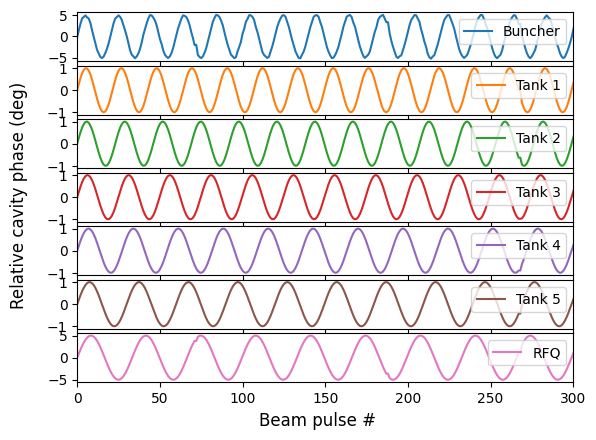

In [137]:
# For demonstration: how are we changing cavity phases?
# Oscillating them all together in sinewaves with different frequencies
%matplotlib inline
fig,ax = plt.subplots(7,sharex=True)
colors = [p['color'] for p in plt.rcParams['axes.prop_cycle']]

for i, cav in enumerate(cavs[:7]):
    ax[i].plot(reference[0][cav],label='%s'%cavnames[i],c=colors[i])
    ax[i].legend(loc='upper right',bbox_to_anchor=(1,1))
    ax[i].set_xlim(0,300)

fig.supxlabel('Beam pulse #')
fig.supylabel('Relative cavity phase (deg)')
plt.subplots_adjust(wspace=0, hspace=0.1)

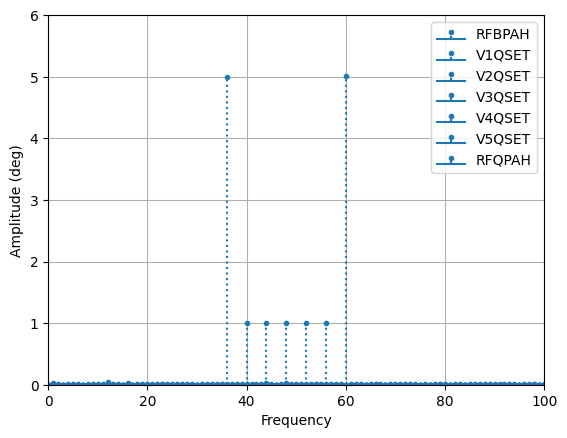

In [138]:
# Sanity check in Fourier space: are cavity phases oscillating at the desired frequencies and amplitudes?
raw_ffts = apply_FFT(reference)

Nper = 4
Npt = 299
plot_fft(raw_ffts[0],cavs,Npt,Nper)

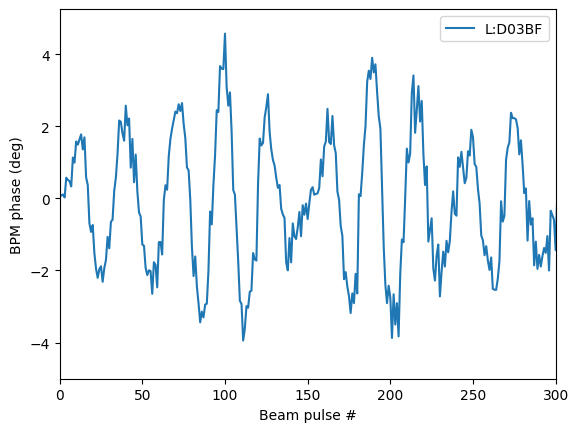

In [139]:
# For demonstration purposes.
# What does the beam phase combined response look like? It is the combined effect of 7 cavities oscillating
# L:D03BF is the data from one sensor
plt.plot(reference[0]['L:D03BF'],label='L:D03BF')
#plt.plot(dfs[0]['L:D12BF'],label='L:D12BF') # different location
plt.xlim(0,300)
plt.xlabel('Beam pulse #')
plt.ylabel('BPM phase (deg)')
plt.legend()

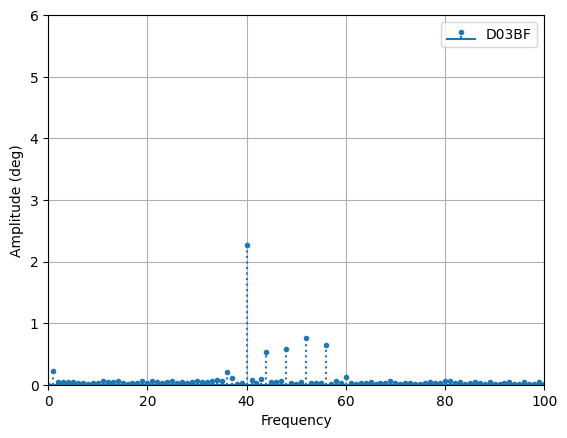

In [140]:
# And here is the response in Fourier space.
# We see 7 peaks corresponding to the 7 cavities + noise
plot_fft(raw_ffts[0],['L:D03BF'],Npt,Nper)

In [141]:
# select only relevant columns from dataframe
reference[0] = reference[0][cavs+BPM_list]

In [142]:
# Calculate and plot response matrix: how beam phase changes in response to cavity phase change
refs = apply_FFT_filter(reference[0],cavs,BPM_list,tolerance=0.0001)
response_matrix = calc_response_matrix(refs,cavs)

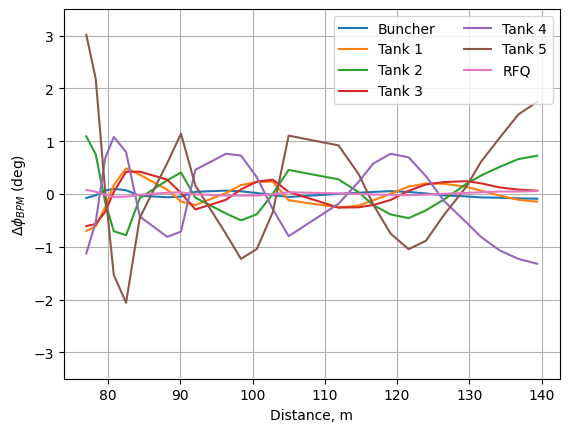

In [143]:
%matplotlib inline
response_matrix_bpm = [r[BPM_list] for r in response_matrix]
plot_basis_vectors(response_matrix_bpm,cavs,range(len(response_matrix_bpm)))

In [144]:
# Select 2 basis vectors out of the 7
show_basis_choices(response_matrix_bpm)
#basis_choice = select_basis(response_matrix_bpm,basis_choice_override=(0,1))
# we can force the choice of basis vectors. If not forced, it will look for "orthogonality" (see function body)
basis_choice = select_basis(response_matrix_bpm,basis_choice_override=None)

(0, 1) 0.27961901569415704
(0, 2) -0.8670116040802271
(0, 3) -0.1233579368323805
(0, 4) 0.9856910025722396
(0, 5) -0.7660174020816738
(0, 6) -0.8988990785786257
(1, 2) -0.7080716536561765
(1, 3) 0.9113739698257175
(1, 4) 0.36012551941067195
(1, 5) -0.8236282956598568
(1, 6) -0.6520936324218883
(2, 3) -0.369380052285205
(2, 4) -0.9109201271218615
(2, 5) 0.9812757202613248
(2, 6) 0.9811486147873665
(3, 4) -0.044271676425855215
(3, 5) -0.5254332820524441
(3, 6) -0.3013609853235986
(4, 5) -0.8245456014727126
(4, 6) -0.9210502116687425
(5, 6) 0.9515624705818239


In [145]:
print(basis_choice)

(3, 4)


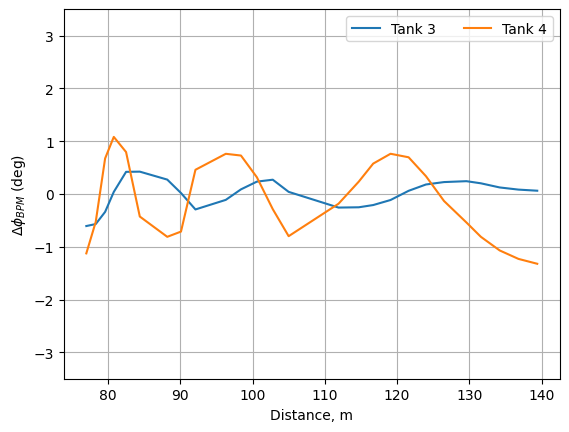

In [146]:
# Sanity check
plot_basis_vectors(response_matrix_bpm,cavs,list(basis_choice))

In [147]:
### Fitting with basis vectors demonstration
# Below we show several tests of the 2-vector fitting

# Test 1: 1-step drift compensation
# Fitting data from Feb 15 and Feb21 to return to Feb 08 state
# Reference file: Feb 29 (I think?)
path = "PhaseCompensation/"
dates = ["20240208_","20240215_","20240215_","20240221_","20240221_"]
times = ["163623_nominal",'143017_nominal2',
         "155508_dailyCorrFeb8_positive","161542_nominal2","162307_dailyCorrFeb8_negative2"]
files = ['%s%s%s.csv'%(path,d,t) for (d,t) in zip(dates,times)]
lbls = ['Feb 08 nominal','Feb 15 relative','Feb 15 corrected','Feb 21 relative','Feb 21 corrected']


'''
# Test 2: 1-step compensation of upstream fluctuation
# Reference file Feb 15
date="20240215_"
lbls = ['Nominal','RFQ +15deg','RFQ Compensated','T1+4deg','T1 Compensated']
times = ['132713_nominal_1000evt','133256_RFQplus15deg','134353_FullyCompensatedT4T5',
         '143412_T1plus4deg','144019_T1FullyCompensatedT4T5']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]


# Test 3: multi-step compensation of upstream fluctuations
# Reference file April 10
date = '20240410_'
lbls = ['Nominal','Buncher+20deg','Compensated step 1','Step 2','Step 3','Step 4']
times = ['151457','152154','155113','160055','160739','161432']
files = [r'%s%s%s.csv'%(filepath,date,t) for t in times]
'''

dfs = load_BPMphase_data_multi(cavs_both,files,devices_to_drop,scan=False)


In [148]:
means = [df[BPM_list].mean() for df in dfs]
stds = [df[BPM_list].std() for df in dfs] #normalized by N-1. Use ddof=0 to normalize by N
#should I be using SEM instead of STD?

In [149]:
# Calculate difference from nominal
diffs = [m - means[0] for m in means]
errs = [np.sqrt(s**2 + stds[0]**2) for s in stds]

In [150]:
dfs[3].columns

Index(['L:RFQPAH', 'L:RFBPAH', 'L:V1QSET', 'L:V2QSET', 'L:V3QSET', 'L:V4QSET',
       'L:V5QSET', 'L:V1SQ', 'L:V2SQ', 'L:V3SQ', 'L:V4SQ', 'L:V5SQ', 'L:D02BF',
       'L:D03BF', 'L:D11BF', 'L:D12BF', 'L:D13BF', 'L:D21BF', 'L:D22BF',
       'L:D23BF', 'L:D31BF', 'L:D32BF', 'L:D33BF', 'L:D34BF', 'L:D41BF',
       'L:D42BF', 'L:D43BF', 'L:D51BF', 'L:D52BF', 'L:D53BF', 'L:D54BF',
       'L:D61BF', 'L:D62BF', 'L:D63BF', 'L:D64BF', 'L:D71BF', 'L:D72BF',
       'L:D73BF', 'L:D74BF'],
      dtype='object')

In [151]:
# Calculate phase setting changes

#meanrf = [df[cavs].mean() for df in dfs]
#deltarf = [mrf - meanrf[0] for mrf in meanrf]
#print([drf[cavs] for drf in deltarf[1:]])

<ipython-input-130-65b95d6c0d31>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(osc_array, dtype=torch.float32)


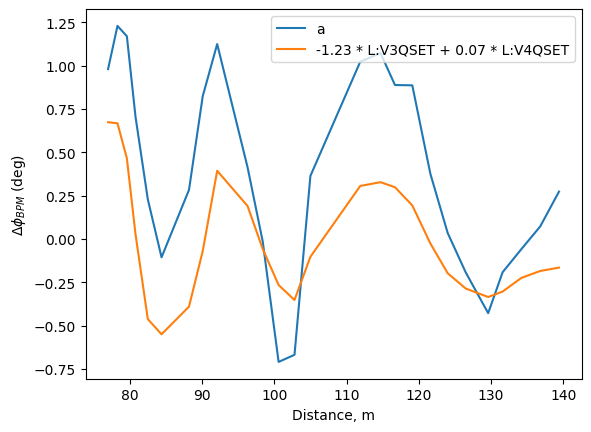

In [152]:
plot_fit_traj(cavs,diffs[1],basis_choice,response_matrix,'a')

<ipython-input-130-65b95d6c0d31>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = torch.tensor(osc_array, dtype=torch.float32)


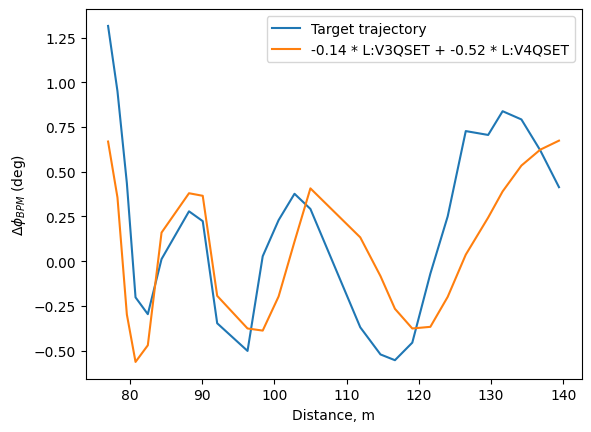

In [153]:
plot_fit_traj(cavs,diffs[-1],basis_choice,response_matrix)

In [154]:
# Metrics
for i,(diff,err) in enumerate(zip(diffs,errs)):
    print(r'%s mean'%lbls[i],diff.mean())
    print(r'%s STD'%lbls[i],diff.std())
    print(r'%s err'%lbls[i],err.mean())
    print(r'%s err/sqrt(N)'%lbls[i],err.mean()/np.sqrt(dfs[i].shape[0]))

Feb 08 nominal mean 0.0
Feb 08 nominal STD 0.0
Feb 08 nominal err 0.5028825624327904
Feb 08 nominal err/sqrt(N) 0.015910500168586278
Feb 15 relative mean 0.3686971789999088
Feb 15 relative STD 0.57972567773329
Feb 15 relative err 0.5173629778698481
Feb 15 relative err/sqrt(N) 0.016368640238382984
Feb 15 corrected mean 0.29826138734982727
Feb 15 corrected STD 0.31536004989514105
Feb 15 corrected err 0.5132486557362268
Feb 15 corrected err/sqrt(N) 0.016230347581461215
Feb 21 relative mean -0.03217693897229189
Feb 21 relative STD 1.387380506937479
Feb 21 relative err 0.5363418575024448
Feb 21 relative err/sqrt(N) 0.016960618741931936
Feb 21 corrected mean 0.19915923755034998
Feb 21 corrected STD 0.5138264903374351
Feb 21 corrected err 0.5293409467416688
Feb 21 corrected err/sqrt(N) 0.01674760640263509


(-4.0, 4.0)

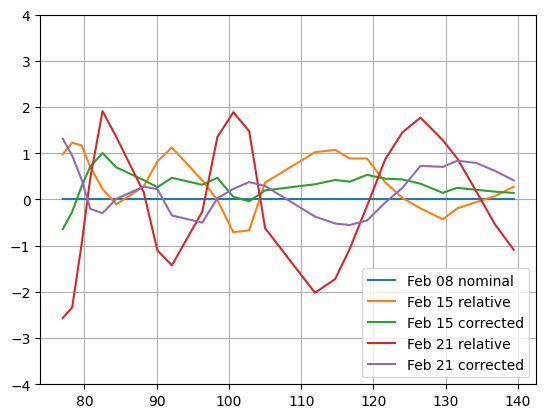

In [155]:
#%matplotlib widget
#[plt.errorbar(dist_data,diff,yerr=err,label=lbls[i]) for i,(diff,err) in enumerate(zip(diffs,errs))];
[plt.plot(dist_data,diff,label=lbl) for (diff,lbl) in zip(diffs[:],lbls[:])];
plt.legend()
plt.grid()
plt.ylim(-4,4)